In [51]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.axes_grid1 import make_axes_locatable
import math 


mpl.rcParams['figure.dpi'] = 120

#### Settings

In [143]:
# 1 inch = 0.0254 m so approximatively 0.025 m
# 10 inches = 0.25m 
# 1 hectare = 10000m^2 therefore 100m*100m
# 100m = 0.25m*400 = 10in * 400 = 4000in

P_max = 100 # Max number of dandelion heads
length = 400
seeds_produced = (150+200)/2 # https://www.canr.msu.edu/weeds/extension/dandelion#:~:text=Seed%3A,because%20they%20move%20in%20updrafts.
survival_rate = (float) (0.02+0.13)/2  
'''In another experiment recording the fate of dandelion seeds shed in spring, 29 to 48% of seeds became nonviable, 35 to 44% were consumed by ground beetles, 
5 to 25% were consumed as seedlings by slugs, and only 2 to 13% survived as seedlings (Honek et al. 2009).
https://cals.cornell.edu/weed-science/weed-profiles/dandelion
'''

land = np.zeros((length, length))
land[0][0] = 1 #initial dandelion

moisture_level = 1
sunlight_level = (float) (5/11) # Sunlight stays constant throughout the year because we are considering avg sunlight 
# https://www.researchgate.net/figure/Variation-of-sunshine-hours-with-months-of-the-year_fig1_268330578 - avg sunshine duration is 5h / day throughout the year
# Max sunshine level https://en.wikipedia.org/wiki/Sunshine_duration#:~:text=The%20city%20claiming%20the%20official,sunnier%20areas%20in%20North%20Africa: 11h/day on avg


avg_rain = 10 # per month, assuming that each day of precipitation grants 0.1 moisture
avg_iteration = 10 # n of iterations per month

moisture = np.full((length, length), moisture_level) 
sunlight = np.full((length, length), sunlight_level)

In [118]:
# Defining wind as a NE direction for matrix
wind = np.zeros((length+1, length+1))
wind[0][0] = 0.001
# Set length = length+1 to make it easier to calculate in the future 

angle = 10
rad = math.radians(angle) # angle in deg
relation = math.sin(rad)/math.cos(rad)
print(relation)

diagonal = [[0,0]]

if (angle <= 45):

    for j in range(1, length+1):
        y = (int) ((j*relation))
        if (y >= length+1):
            diagonal.append([-1, -1])
            continue
        diagonal.append([y, j])

        wind[y][j] = (float) ((j)/400)

    # Fill the rest

    #Proces upper diagonal 
    for j in range(length+1-1, -1, -1):
        for i in range(diagonal[j][0]+1, length+1):
            if (wind[i][j] == 0):
                if (j+1 < length+1):
                    wind[i][j] = (float) (wind[i-1][j] + wind[i][j+1])/2

    #Process lower diagonal
    for j in range(1, length+1):
        for i in range(diagonal[j][0], -1, -1):
            if (wind[i][j] == 0):
                wind[i][j] = (float) (wind[i+1][j] + wind[i][j-1])/2
elif angle > 45:

    for i in range(1, length+1):
        x = (int) ((i/relation))
        if (x >= length+1):
            diagonal.append([-1, -1])
            continue
        diagonal.append([i, x])

        wind[i][x] = (float) ((i+1)/400)
    
    #Process upper diagonal
    for i in range(1, length+1):
        for j in range(diagonal[i][1], -1, -1):
            if (wind[i][j] == 0):
                wind[i][j] = (float) (wind[i-1][j] + wind[i][j+1])/2

    out = False

    #Process lower diagonal
    for i in range(length+1-1, -1, -1):
        print(i)
        for j in range(diagonal[i][1]+1, length+1):
            print(j)
            if (wind[i][j] == 0):
                if (i+1 < length+1):
                    wind[i][j] = (float) (wind[i+1][j] + wind[i][j-1])/2
                
        

0.17632698070846498


#### Definitions

In [103]:
def show(land, moisture, sunlight, wind):
    fig, (ax1, ax2) = plt.subplots(2, 2)
    im1 = ax1[0].imshow(land, origin='lower')
    ax1[0].set_title("Land Plot")
    im2 = ax1[1].imshow(moisture, origin='lower')
    ax1[1].set_title("Moisture")
    im3 = ax2[0].imshow(sunlight, origin='lower')
    ax2[0].set_title("Sunlight")
    im4 = ax2[1].imshow(wind, origin='lower')
    ax2[1].set_title("Wind")
    fig.tight_layout(pad=1.0)

    count = 1
    for i in range(1, 3):
        for j in range(2):
            divider = make_axes_locatable(eval("ax"+str(i)+"["+str(j)+"]"))
            cax = divider.append_axes('right', size='5%', pad=0.05)
            fig.colorbar(eval("im"+str(count)), cax=cax)
            count+=1


    plt.show()

In [102]:
def grass_prop(x, y):
    return 1-(land[x][y]/P_max)

def dandelion_prop(x, y):
    return (land[x][y]/P_max)

In [101]:
def update_moisture():
    # first we update moisture

    for i in range(len(moisture)):
        for j in range(len(moisture)):
            moisture[i][j] = moisture[i][j]+avg_rain*10 # Take into account all the precipitation

    for i in range(len(land)):
        for j in range(len(land)):
            moisture[i][j] -= (grass_prop(i, j)*1) + (dandelion_prop(i,j) * 1.5)
            moisture[i][j] = min(moisture[i][j], 1) # bring back moisture to 0 - 1 range once adjusted 

#### Code

In [144]:
print(len(wind[400]))

getout = False
count = 0

for month in range(1, 2):
    print("month ", month)


    for it in range(avg_iteration):
        # For each square, determine the number of seeds and check seed transfer based on the wind direction. 

        seeds = np.zeros((length, length)) 
        transfered_seeds = np.zeros((length, length)) # received seeds

        for i in range(length):
            for j in range(length):
                right = min(j+1, length) # Don't go out of bounds (doesn't happen but as backup)
                top = min(i+1, length)

                for y in range(3):
                    for x in range(3):
                        if (i+y < length and j+x<length):
                            wind_sum+=wind[i+y][j+x]

                wind_sum = wind[i][j] + wind[i][right] + wind[top][j] + wind[top][right]

                # print(total_seeds)

                total_seeds = seeds[i][j] + (int) (land[i][j]*seeds_produced*survival_rate)
                # seeds[i][j] += transfered_seeds[i][j]
                seeds[i][j] = round((wind[i][j]/wind_sum)*total_seeds)
                total_give = 0

                for y in range(3):
                    for x in range(3):
                        if (i+y < length and j+x<length):
                            seeds[i+y][j+x] += round((wind[i+y][j+x]/wind_sum)*total_seeds)
                
                # if (right < length):
                #     transfered_seeds[i][right] += round((wind[i][right]/wind_sum)*total_seeds)
                # if (top < length):
                #     transfered_seeds[top][j] += round((wind[top][j]/wind_sum)*total_seeds)
                # if (right < length and top < length):
                #     transfered_seeds[top][right] += round((wind[top][right]/wind_sum)*total_seeds)

                count+=1
                
                # if (count==800):
                #     getout = True
                #     break
            if getout:
                break
        if getout: break

        print(seeds)
        # Convert seeds to dandelions:

        for i in range(length):
            for j in range(length):
                land[i][j] = min(100, land[i][j]+seeds[i][j])
                
                
            


401
month  1
[[1. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[2. 1. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[5. 3. 1. ... 0. 0. 0.]
 [4. 1. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[10. 10.  6. ...  0.  0.  0.]
 [14.  6.  2. ...  0.  0.  0.]
 [ 6.  2.  0. ...  0.  0.  0.]
 ...
 [ 0.  0.  0. ...  0.  0.  0.]
 [ 0.  0.  0. ...  0.  0.  0.]
 [ 0.  0.  0. ...  0.  0.  0.]]
[[22. 30. 26. ...  0.  0.  0.]
 [46. 28. 13. ...  0.  0.  0.]
 [30. 13.  3. ...  0.  0.  0.]
 ...
 [ 0.  0.  0. ...  0.  0.  0.]
 [ 0.  0.  0. ...  0.  0.  0.]
 [ 0.  0.  0. ...  0.  0.  0.]]
[[ 47.  88. 103. ...   0.   0.   0.]
 [146. 119.  72. ...   0.   0.   0.]
 [129.  72.  28. ...   0.   0.   0.]
 ...
 [  0.   0.   0. ..

In [114]:
wind[1][1]

0.004921875

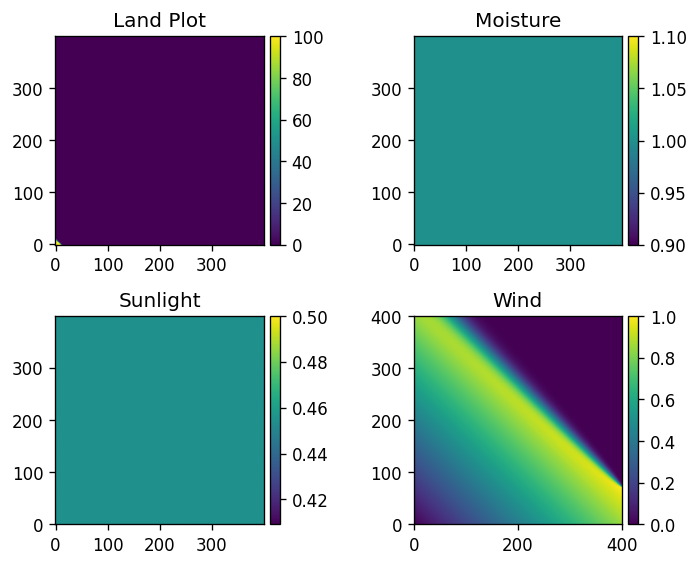

In [145]:
show(land, moisture, sunlight, wind)

(0.0, 25.0, 0.0, 25.0)

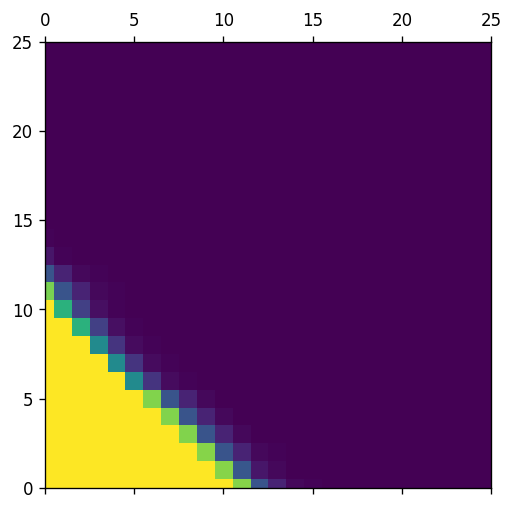

In [146]:
plt.matshow(land)
plt.axis([0, 25, 0, 25])